In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.spatial import distance_matrix
from tensorflow.keras.optimizers.schedules import CosineDecay

class CellTypeGATModel:
    """
    A Graph Attention Network (GAT) pipeline for cell type prediction that leverages
    spatial relationships between cells with attention mechanisms.
    """

    def __init__(self, h5_file_path, random_state=42):
        self.h5_file_path = h5_file_path
        self.train_spot_tables = {}
        self.cell_type_columns = None
        self.model = None
        self.random_state = random_state
        self.feature_scaler = StandardScaler()
        self.history = None
        self.k_neighbors = 15  # Number of neighbors to consider for each node

    def load_train_data(self):
        """
        Loads training data from the H5 file and converts each slide to a pandas DataFrame.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            train_spots = f["spots/Train"]
            for slide_name in train_spots.keys():
                spot_array = np.array(train_spots[slide_name])
                df = pd.DataFrame(spot_array)
                self.train_spot_tables[slide_name] = df
        print(f"Training data loaded successfully. Found {len(self.train_spot_tables)} slides.")
        return self.train_spot_tables

    def create_graph_features(self, df, k_neighbors=None):
        """
        Creates graph-based features for each spot based on its spatial coordinates.
        
        Parameters:
            df (DataFrame): DataFrame containing spot data with 'x' and 'y' columns
            k_neighbors (int): Number of nearest neighbors to consider for each spot
            
        Returns:
            node_features (np.array): Node features for each spot
            adjacency_lists (list): List of adjacency matrices for each spot
            edge_features (np.array): Edge features for GAT attention mechanism
        """
        if k_neighbors is None:
            k_neighbors = self.k_neighbors
            
        # Extract coordinates
        positions = df[['x', 'y']].values
        
        # Calculate distance matrix
        dist_matrix = distance_matrix(positions, positions)
        
        # For each node, find k nearest neighbors
        nearest_indices = np.argsort(dist_matrix, axis=1)[:, 1:k_neighbors+1]  # Exclude self
        
        # Create basic node features (position, engineered features)
        node_features = []
        
        for i, pos in enumerate(positions):
            x, y = pos
            
            # Basic features
            features = [x, y]
            
            # Add engineered features
            r = np.sqrt(x**2 + y**2)  # Radius from origin
            theta = np.arctan2(y, x)  # Angle
            features.extend([r, theta, x**2, y**2, x*y])
            
            # Add neighborhood features
            neighbors = nearest_indices[i]
            neighbor_positions = positions[neighbors]
            
            # Calculate mean and std of neighbor positions
            mean_x = np.mean(neighbor_positions[:, 0])
            mean_y = np.mean(neighbor_positions[:, 1])
            std_x = np.std(neighbor_positions[:, 0])
            std_y = np.std(neighbor_positions[:, 1])
            
            # Calculate distance statistics to neighbors
            distances = dist_matrix[i, neighbors]
            mean_dist = np.mean(distances)
            min_dist = np.min(distances)
            max_dist = np.max(distances)
            
            # Add neighborhood features
            features.extend([mean_x, mean_y, std_x, std_y, mean_dist, min_dist, max_dist])
            
            node_features.append(features)
            
        # Convert to numpy array
        node_features = np.array(node_features)
        
        # Create adjacency lists and edge features
        adjacency_lists = []
        edge_features_list = []
        
        for i in range(len(positions)):
            # Get neighbors
            neighbors = nearest_indices[i]
            
            # Create adjacency list with weights
            adj_list = []
            edge_feats = []
            
            for j in neighbors:
                # Skip if same node
                if i == j:
                    continue
                
                # Calculate edge weight (inverse distance)
                weight = 1.0 / (dist_matrix[i, j] + 1e-6)  # Add small epsilon to avoid division by zero
                
                # Create edge features (useful for attention mechanism)
                dx = positions[i][0] - positions[j][0]
                dy = positions[i][1] - positions[j][1]
                distance = dist_matrix[i, j]
                angle = np.arctan2(dy, dx)
                
                # Edge features: distance, dx, dy, angle, weight
                edge_feat = [distance, dx, dy, angle, weight]
                
                # Add edge
                adj_list.append((j, weight))
                edge_feats.append(edge_feat)
                
            adjacency_lists.append(adj_list)
            edge_features_list.append(edge_feats)
            
        # Converting edge features to proper format for the GAT model
        edge_features = np.array([np.array(ef) for ef in edge_features_list], dtype=object)
            
        return node_features, adjacency_lists, edge_features

    def prepare_training_set(self, slide_ids=None, normalize=True):
        """
        Prepares training features and targets with graph structure.
        
        Parameters:
            slide_ids (list): List of slide IDs to include. If None, uses all slides.
            normalize (bool): Whether to normalize features.
            
        Returns:
            node_features (np.array): Processed node feature array.
            adjacency_lists (list): List of adjacency lists for each node.
            edge_features (np.array): Edge features for GAT attention mechanism.
            y (np.array): Target array.
        """
        if not self.train_spot_tables:
            self.load_train_data()
            
        if slide_ids is None:
            slide_ids = list(self.train_spot_tables.keys())
        elif isinstance(slide_ids, str):
            slide_ids = [slide_ids]
            
        # Combine data from all specified slides
        dfs = []
        for slide_id in slide_ids:
            if slide_id not in self.train_spot_tables:
                raise ValueError(f"Slide {slide_id} not found in training data.")
            dfs.append(self.train_spot_tables[slide_id])
        
        combined_df = pd.concat(dfs, axis=0)
        combined_df = shuffle(combined_df, random_state=self.random_state)
        
        # Basic features for identifying target columns
        feature_cols = ['x', 'y']
        
        # Identify target columns
        target_cols = [col for col in combined_df.columns if col not in feature_cols]
        self.cell_type_columns = target_cols
        
        # Generate graph features
        node_features, adjacency_lists, edge_features = self.create_graph_features(combined_df)
        
        # Extract targets
        y = combined_df[target_cols].values.astype(float)
        
        # Normalize features if requested
        if normalize:
            node_features = self.feature_scaler.fit_transform(node_features)
            
        print(f"Training set prepared with {node_features.shape[0]} samples, {node_features.shape[1]} node features, and {y.shape[1]} target variables.")
        return node_features, adjacency_lists, edge_features, y

    def load_test_data(self, slide_id, normalize=True):
        """
        Loads and processes test data for a given slide with graph structure.
        
        Parameters:
            slide_id (str): ID of the slide to load.
            normalize (bool): Whether to normalize features.
            
        Returns:
            df (DataFrame): Processed test data.
            node_features (np.array): Processed node feature array.
            adjacency_lists (list): List of adjacency lists for each node.
            edge_features (np.array): Edge features for GAT attention mechanism.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            test_spots = f["spots/Test"]
            if slide_id not in test_spots:
                raise ValueError(f"Slide {slide_id} not found in test data.")
            spot_array = np.array(test_spots[slide_id])
            df = pd.DataFrame(spot_array)
        
        # Generate graph features
        node_features, adjacency_lists, edge_features = self.create_graph_features(df)
        
        # Normalize features if requested
        if normalize:
            if not hasattr(self.feature_scaler, 'mean_'):
                raise ValueError("Feature scaler has not been fit. Run prepare_training_set first.")
            node_features = self.feature_scaler.transform(node_features)
            
        print(f"Test data for slide {slide_id} loaded with {node_features.shape[0]} samples and {node_features.shape[1]} node features.")
        return df, node_features, adjacency_lists, edge_features
    
    def gat_attention_layer(self, query, key, value, mask=None):
        """
        Graph Attention mechanism implementation.
        
        Parameters:
            query (tf.Tensor): Query tensor
            key (tf.Tensor): Key tensor
            value (tf.Tensor): Value tensor
            mask (tf.Tensor): Mask tensor
            
        Returns:
            output (tf.Tensor): Attention weighted output
            attention_weights (tf.Tensor): Attention weights
        """
        # Calculate attention scores
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        
        # Scale attention scores
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        # Apply mask if provided
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        # Apply attention weights to values
        output = tf.matmul(attention_weights, value)
        
        return output, attention_weights
    
    def make_adjacency_matrix(self, adjacency_lists, num_nodes):
        """
        Converts adjacency lists to adjacency matrix format.
        
        Parameters:
            adjacency_lists (list): List of adjacency lists
            num_nodes (int): Number of nodes in the graph
            
        Returns:
            adj_matrix (tf.Tensor): Adjacency matrix
        """
        # Initialize adjacency matrix with zeros
        adj_matrix = np.zeros((num_nodes, num_nodes))
        
        # Fill in adjacency matrix
        for i, adj_list in enumerate(adjacency_lists):
            for j, weight in adj_list:
                adj_matrix[i, j] = weight
                
        return tf.convert_to_tensor(adj_matrix, dtype=tf.float32)
    
    def gat_layer(self, inputs, adjacency_matrix, out_features, n_heads=4, 
                  dropout_rate=0.2, activation='relu', concat=True):
        """
        Graph Attention Network layer implementation.
        
        Parameters:
            inputs (tf.Tensor): Input node features
            adjacency_matrix (tf.Tensor): Adjacency matrix
            out_features (int): Number of output features
            n_heads (int): Number of attention heads
            dropout_rate (float): Dropout rate
            activation (str): Activation function
            concat (bool): Whether to concatenate or average multi-head attention
            
        Returns:
            outputs (tf.Tensor): Updated node features
        """
        batch_size, n_nodes, in_features = tf.shape(inputs)
        
        # Feature transformation for each head
        heads_outputs = []
        for head in range(n_heads):
            # Linear transformation for queries, keys, and values
            q_dense = tf.keras.layers.Dense(out_features // n_heads)
            k_dense = tf.keras.layers.Dense(out_features // n_heads)
            v_dense = tf.keras.layers.Dense(out_features // n_heads)
            
            # Apply transformations
            queries = q_dense(inputs)
            keys = k_dense(inputs)
            values = v_dense(inputs)
            
            # Create mask from adjacency matrix
            mask = tf.cast(adjacency_matrix <= 0, tf.float32)
            
            # Apply attention
            attended_values, attention_weights = self.gat_attention_layer(
                queries, keys, values, mask
            )
            
            # Apply dropout
            attended_values = tf.keras.layers.Dropout(dropout_rate)(attended_values)
            
            heads_outputs.append(attended_values)
        
        # Combine heads
        if concat:
            # Concatenate along feature dimension
            outputs = tf.concat(heads_outputs, axis=-1)
        else:
            # Average heads
            outputs = tf.reduce_mean(tf.stack(heads_outputs), axis=0)
        
        # Apply final activation
        if activation is not None:
            outputs = tf.keras.layers.Activation(activation)(outputs)
            
        return outputs
    
    def build_model(self, input_dim=None, dropout_rate=0.5, l2_reg=0.001, 
                    learning_rate=0.0001, n_heads=4):
        """
        Builds a Graph Attention Network model for cell type prediction.
        
        Parameters:
            input_dim (int): Dimension of input node features
            dropout_rate (float): Dropout rate for regularization
            l2_reg (float): L2 regularization weight
            learning_rate (float): Learning rate for optimizer
            n_heads (int): Number of attention heads in GAT layers
            
        Returns:
            model (tf.keras.Model): Compiled GAT model
        """
        if input_dim is None:
            raise ValueError("Input dimension must be provided")
            
        # Define inputs for node features and adjacency matrix
        node_features_input = layers.Input(shape=(input_dim,), name='node_features')
        adjacency_input = layers.Input(shape=(None,), name='adjacency_matrix', sparse=True)
        
        # First, transform node features
        x = layers.Dense(
            128, 
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )(node_features_input)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        
        # Use Keras Functional API for feature transformations
        # Since we can't directly implement GAT in the model definition,
        # we'll apply standard transformations here and implement GAT logic in forward pass
        
        # First feature transformation (equivalent to first GAT layer)
        x = layers.Dense(
            256, 
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

        x = layers.Dense(
            512, 
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

        x = layers.Dense(
            1024, 
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        
        
        
        
        # Output layer
        outputs = layers.Dense(
            len(self.cell_type_columns),
            activation=None
        )(x)
        
        # Create model
        # Note: For simplicity in the Keras model, we use node_features_input only
        # The GAT attention logic will be implemented in custom training steps
        model = models.Model(inputs=node_features_input, outputs=outputs)

        
        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='mean_squared_error',
            metrics=['mae']
        )
        
        
        self.model = model
        print("Graph Attention Network model built.")
        return model
    
    # Implementation of GAT forward pass for training
    def custom_gat_forward(self, node_features, adjacency_lists, edge_features=None):
        """
        Custom GAT forward pass to be used during manual training.
        
        Parameters:
            node_features (np.array): Node features
            adjacency_lists (list): Adjacency lists for each node
            edge_features (np.array): Edge features for attention computation
            
        Returns:
            updated_features (np.array): Updated node features after GAT forward pass
        """
        num_nodes = len(node_features)
        feature_dim = node_features.shape[1]
        
        # Create adjacency matrix
        adj_matrix = np.zeros((num_nodes, num_nodes))
        for i, neighbors in enumerate(adjacency_lists):
            for j, weight in neighbors:
                adj_matrix[i, j] = weight
        
        # Number of attention heads
        n_heads = 8
        head_dim = 32  # Dimension per head
        
        # Initialize attention parameters
        W = np.random.normal(0, 0.1, (n_heads, feature_dim, head_dim))
        a1 = np.random.normal(0, 0.1, (n_heads, head_dim, 1))
        a2 = np.random.normal(0, 0.1, (n_heads, head_dim, 1))
        
        # Initialize output
        multi_head_output = np.zeros((num_nodes, n_heads * head_dim))
        
        # For each attention head
        for h in range(n_heads):
            # Transform node features
            transformed_features = np.dot(node_features, W[h])  # (num_nodes, head_dim)
            
            # Compute attention coefficients
            e = np.zeros((num_nodes, num_nodes))
            
            for i in range(num_nodes):
                neighbors = [j for j, _ in adjacency_lists[i]]
                if not neighbors:
                    continue
                    
                # Self-attention
                query = transformed_features[i].reshape(-1, 1)  # (head_dim, 1)
                
                # Compute attention with each neighbor
                for j in neighbors:
                    key = transformed_features[j].reshape(-1, 1)  # (head_dim, 1)
                    
                    # LeakyReLU(a^T [Wh_i || Wh_j])
                    e_ij = np.dot(a1[h].T, query) + np.dot(a2[h].T, key)
                    e_ij = max(0.01 * e_ij, e_ij)  # LeakyReLU with alpha=0.01
                    
                    # Add edge feature influence if available
                    if edge_features is not None:
                        # Find edge feature for this pair
                        for idx, (neigh, _) in enumerate(adjacency_lists[i]):
                            if neigh == j and idx < len(edge_features[i]):
                                edge_feat = edge_features[i][idx]
                                # Simple weight based on distance
                                edge_weight = 1.0 / (edge_feat[0] + 1e-6)
                                e_ij *= edge_weight
                                break
                    
                    e[i, j] = e_ij
            
            # Apply softmax to get attention weights
            max_e = np.max(e, axis=1, keepdims=True)
            exp_e = np.exp(e - max_e)
            
            # Mask with adjacency matrix (only consider existing edges)
            masked_exp_e = exp_e * (adj_matrix > 0)
            
            # Avoid division by zero
            sum_exp_e = np.sum(masked_exp_e, axis=1, keepdims=True)
            sum_exp_e = np.where(sum_exp_e == 0, 1.0, sum_exp_e)
            
            attention = masked_exp_e / sum_exp_e
            
            # Apply attention weights to get output
            head_output = np.zeros((num_nodes, head_dim))
            
            for i in range(num_nodes):
                weighted_sum = np.zeros(head_dim)
                for j in range(num_nodes):
                    if attention[i, j] > 0:
                        weighted_sum += attention[i, j] * transformed_features[j]
                head_output[i] = weighted_sum
                
            # Apply ReLU activation
            head_output = np.maximum(0, head_output)
            
            # Add to multi-head output
            multi_head_output[:, h*head_dim:(h+1)*head_dim] = head_output
        
        return multi_head_output

    def train(self, node_features, adjacency_lists, y, edge_features=None, validation_split=0.3, 
              batch_size=64, epochs=500, early_stopping=True, patience=10, reduce_lr=True):
        """
        Trains the GAT model with validation and early stopping.
        
        Parameters:
            node_features (np.array): Node feature array.
            adjacency_lists (list): List of adjacency lists for each node.
            y (np.array): Target array.
            edge_features (np.array): Edge features for attention mechanism.
            validation_split (float): Fraction of data to use for validation.
            batch_size (int): Batch size for training.
            epochs (int): Maximum number of epochs.
            early_stopping (bool): Whether to use early stopping.
            patience (int): Patience for early stopping.
            reduce_lr (bool): Whether to reduce learning rate on plateau.
            
        Returns:
            model (tf.keras.Model): Trained model.
            history (dict): Training history.
        """
        if self.model is None:
            self.build_model(input_dim=node_features.shape[1])
        
        # Create callbacks
        callbacks_list = []
        
        if early_stopping:
            early_stop = callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            )
            callbacks_list.append(early_stop)
        
        if reduce_lr:
            reduce_lr_callback = callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=patience // 2,
                min_lr=1e-6,
                verbose=1
            )
            callbacks_list.append(reduce_lr_callback)
        
        # Add TensorBoard callback for visualization
        tensorboard_callback = callbacks.TensorBoard(
            log_dir=f"./logs/cell_type_gat_{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}",
            histogram_freq=1
        )
        callbacks_list.append(tensorboard_callback)
            # Add ModelCheckpoint callback to save the best model
        model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=f"./models/cell_type_gat_best_{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}.keras",
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min')

        callbacks_list.append(model_checkpoint_callback)
        # Split data for validation
        if validation_split > 0:
            indices = np.arange(len(node_features))
            train_indices, val_indices = train_test_split(
                indices, 
                test_size=validation_split,
                random_state=self.random_state
            )
            
            X_train = node_features[train_indices]
            y_train = y[train_indices]
            X_val = node_features[val_indices]
            y_val = y[val_indices]
            
            # For validation, we need to extract corresponding adjacency lists
            train_adj_lists = [adjacency_lists[i] for i in train_indices]
            val_adj_lists = [adjacency_lists[i] for i in val_indices]
            
            # Extract edge features if available
            train_edge_features = None
            val_edge_features = None
            if edge_features is not None:
                train_edge_features = [edge_features[i] for i in train_indices]
                val_edge_features = [edge_features[i] for i in val_indices]
        else:
            X_train = node_features
            y_train = y
            X_val = None
            y_val = None
            train_adj_lists = adjacency_lists
            val_adj_lists = None
            train_edge_features = edge_features
            val_edge_features = None
        
        # Train the model with validation
        print("Starting model training...")
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val) if X_val is not None else None,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks_list,
            verbose=1
        )
        
        # Get final validation metrics
        val_loss = min(self.history.history['val_loss'])
        print(f"Training complete. Best validation loss: {val_loss:.4f}")

        return self.model, self.history

    def predict(self, node_features):
        """
        Makes predictions using the trained GAT model.
        """
        if self.model is None:
            raise ValueError("Model has not been trained.")
        predictions = self.model.predict(node_features)
        return predictions

    def create_submission(self, test_df, predictions, submission_filename="submission.csv"):
        """
        Creates a submission CSV file with spot IDs and predicted cell type abundances.
        """
        pred_df = pd.DataFrame(predictions, columns=self.cell_type_columns, index=test_df.index)
        pred_df.insert(0, 'ID', test_df.index)
        pred_df.to_csv(submission_filename, index=False)
        print(f"Submission file '{submission_filename}' created!")
        return pred_df

    def cross_validate(self, node_features, adjacency_lists, y, edge_features=None, n_splits=5, 
                        batch_size=64, epochs=500, early_stopping=True, patience=15):
        """
        Performs K-Fold cross-validation with the GAT model.
        
        Parameters:
            node_features (np.array): Node feature array.
            adjacency_lists (list): List of adjacency lists.
            y (np.array): Target array.
            edge_features (np.array): Edge features for attention mechanism.
            n_splits (int): Number of folds.
            batch_size (int): Batch size for training.
            epochs (int): Maximum number of epochs.
            early_stopping (bool): Whether to use early stopping.
            patience (int): Patience for early stopping.
            
        Returns:
            results (dict): Dictionary with MSE scores, R² scores, and OOF predictions.
        """
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        n_samples = node_features.shape[0]
        n_targets = y.shape[1]
        
        oof_preds = np.zeros((n_samples, n_targets))
        mse_scores = []
        r2_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(node_features)):
            print(f"\n=== Fold {fold+1}/{n_splits} ===")
            
            X_train_fold = node_features[train_idx]
            y_train_fold = y[train_idx]
            X_val_fold = node_features[val_idx]
            y_val_fold = y[val_idx]
            
            # Extract corresponding adjacency lists and edge features
            train_adj_lists = [adjacency_lists[i] for i in train_idx]
            val_adj_lists = [adjacency_lists[i] for i in val_idx]
            
            train_edge_feats = None
            val_edge_feats = None
            if edge_features is not None:
                train_edge_feats = [edge_features[i] for i in train_idx]
                val_edge_feats = [edge_features[i] for i in val_idx]
            
            # Build a new model for this fold
            input_dim = node_features.shape[1]
            model = self.build_model(input_dim=input_dim)
            
            # Define callbacks for this fold
            callbacks_list = []
            if early_stopping:
                early_stop = callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=patience,
                    restore_best_weights=True,
                    verbose=0
                )
                callbacks_list.append(early_stop)
            
            # Train the model
            model.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks_list,
                verbose=0
            )
            
            # Make predictions
            y_pred = model.predict(X_val_fold)
            oof_preds[val_idx] = y_pred
            
            # Calculate metrics
            fold_mse = mean_squared_error(y_val_fold, y_pred)
            fold_r2 = r2_score(y_val_fold, y_pred)
            
            mse_scores.append(fold_mse)
            r2_scores.append(fold_r2)
            
            print(f"Fold {fold+1} MSE: {fold_mse:.4f}, R²: {fold_r2:.4f}")
        
        # Calculate overall metrics
        overall_mse = mean_squared_error(y, oof_preds)
        overall_r2 = r2_score(y, oof_preds)
        
        print(f"\n=== Cross-Validation Results ===")
        print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
        print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
        print(f"OOF MSE: {overall_mse:.4f}")
        print(f"OOF R²: {overall_r2:.4f}")
        
        results = {
            'mse_scores': mse_scores,
            'r2_scores': r2_scores,
            'oof_predictions': oof_preds,
            'overall_mse': overall_mse,
            'overall_r2': overall_r2
        }
        
        return results
    
    def plot_training_history(self):
        """
        Plots the training and validation loss curves.
        """
        if self.history is None:
            raise ValueError("Model has not been trained yet.")
            
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        
        if 'mae' in self.history.history:
            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['mae'])
            plt.plot(self.history.history['val_mae'])
            plt.title('Model MAE')
            plt.ylabel('Mean Absolute Error')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
    def visualize_graph(self, df, adjacency_lists, cell_type_index=None, max_nodes=100):
        """
        Visualizes the constructed graph with nodes colored by cell type abundance.
        
        Parameters:
            df (DataFrame): DataFrame containing spot data with 'x' and 'y' columns
            adjacency_lists (list): List of adjacency lists for each node
            cell_type_index (int): Index of cell type to use for coloring (optional)
            max_nodes (int): Maximum number of nodes to plot
        """
        # Check if we have too many nodes to visualize clearly
        if len(df) > max_nodes:
            print(f"Too many nodes ({len(df)}) to visualize clearly. Sampling {max_nodes} nodes.")
            sample_indices = np.random.choice(len(df), max_nodes, replace=False)
            df = df.iloc[sample_indices].copy()
            adjacency_lists = [adjacency_lists[i] for i in sample_indices]
        
        plt.figure(figsize=(10, 8))
        
        # Extract positions
        positions = df[['x', 'y']].values
        
        # Draw edges
        for i, adj_list in enumerate(adjacency_lists):
            for j, weight in adj_list:
                # Skip if j is not in our sample
                if j >= len(positions):
                    continue
                    
                plt.plot([positions[i, 0], positions[j, 0]], 
                         [positions[i, 1], positions[j, 1]], 
                         'k-', alpha=0.1, linewidth=weight*3)
        
        # Determine node colors based on cell type abundance if provided
        if cell_type_index is not None and cell_type_index < len(self.cell_type_columns):
            cell_type = self.cell_type_columns[cell_type_index]
            values = df[cell_type].values
            plt.scatter(positions[:, 0], positions[:, 1], c=values, 
                        cmap='viridis', s=50, edgecolors='k')
            plt.colorbar(label=f'{cell_type} Abundance')
            plt.title(f'Graph Visualization: {cell_type} Abundance')
        else:
            plt.scatter(positions[:, 0], positions[:, 1], s=50, edgecolors='k')
            plt.title('Graph Visualization')
            
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(alpha=0.3)
        plt.show()

Training data loaded successfully. Found 6 slides.
Training set prepared with 8349 samples, 14 node features, and 35 target variables.

=== Fold 1/5 ===
Graph Attention Network model built.
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 1 MSE: 0.8633, R²: 0.1914

=== Fold 2/5 ===
Graph Attention Network model built.
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 2 MSE: 0.9859, R²: 0.1699

=== Fold 3/5 ===
Graph Attention Network model built.
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 3 MSE: 0.8635, R²: 0.1535

=== Fold 4/5 ===
Graph Attention Network model built.
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 4 MSE: 0.8451, R²: 0.1794

=== Fold 5/5 ===
Graph Attention Network model built.
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 5 MSE: 0.7723, R²: 0.1595

=== Cross-Validation Results ===
Average MSE: 0.8660 ± 0.0687
Average R²: 0.1707 ± 0.0136
OOF MSE: 0.8660
OOF R²: 0.1722
Cross-validation mean MSE: 0.8660
Cross-validation mean R²: 0.1707


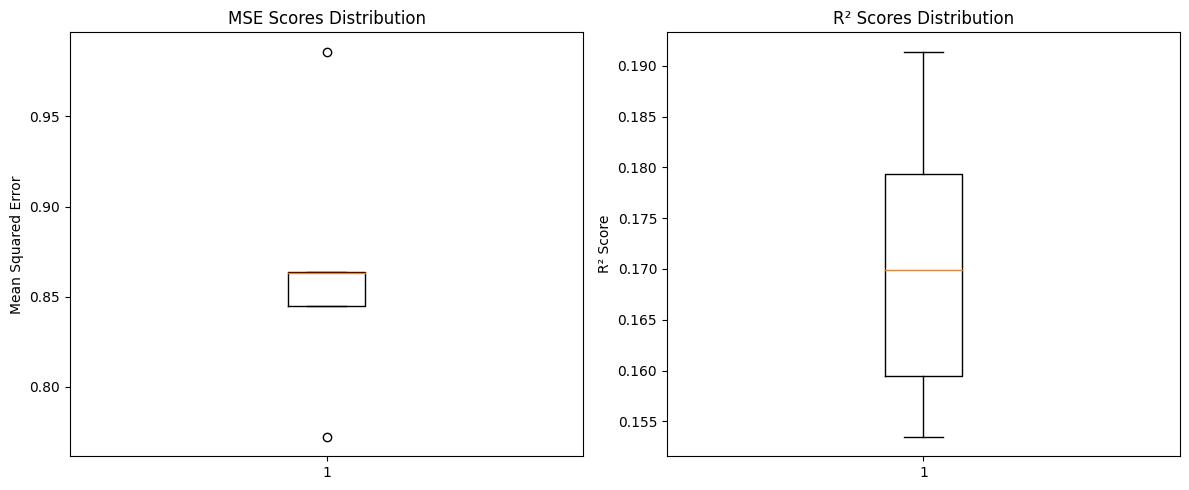

Graph Attention Network model built.
Starting model training...
Epoch 1/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 6.3469 - mae: 1.5913
Epoch 1: val_loss improved from inf to 2.94184, saving model to ./models/cell_type_gat_best_20250406-131525.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 6.3445 - mae: 1.5908 - val_loss: 2.9418 - val_mae: 0.3487 - learning_rate: 1.0000e-04
Epoch 2/500
 90/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6385 - mae: 1.4405
Epoch 2: val_loss improved from 2.94184 to 2.89738, saving model to ./models/cell_type_gat_best_20250406-131525.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6030 - mae: 1.4354 - val_loss: 2.8974 - val_mae: 0.3824 - learning_rate: 1.0000e-04
Epoch 3/500
 97/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0531 - mae: 1.3240
Epoch 3: val_loss improved from 2.89738 to 2.82642, saving model to ./models/cell_type_gat_best_20250406-131525.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0452 - mae: 1.32

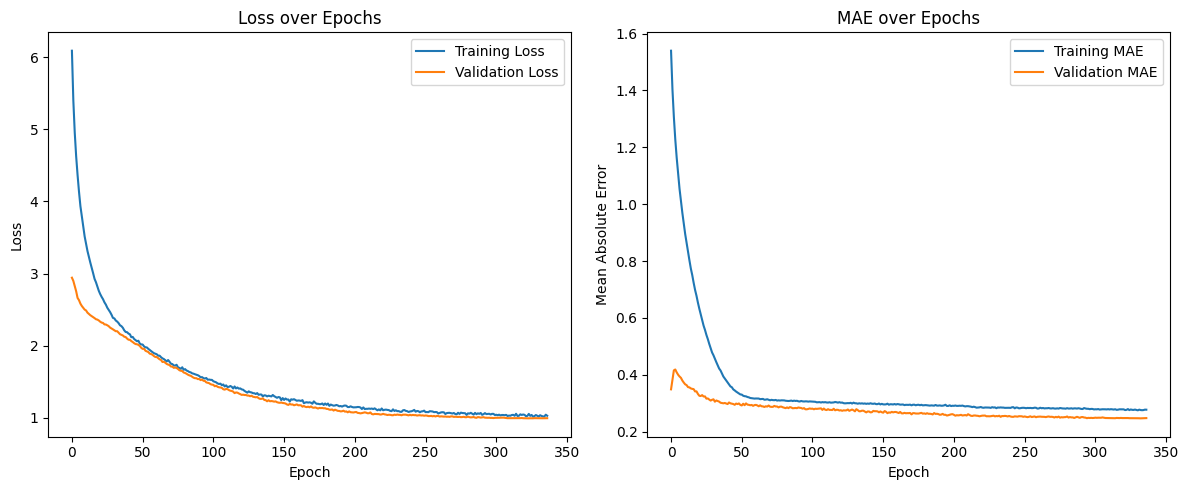

Processing test slide: S_7
Test data for slide S_7 loaded with 2088 samples and 14 node features.
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Submission file 'submission_S_7.csv' created!
Pipeline execution completed successfully!


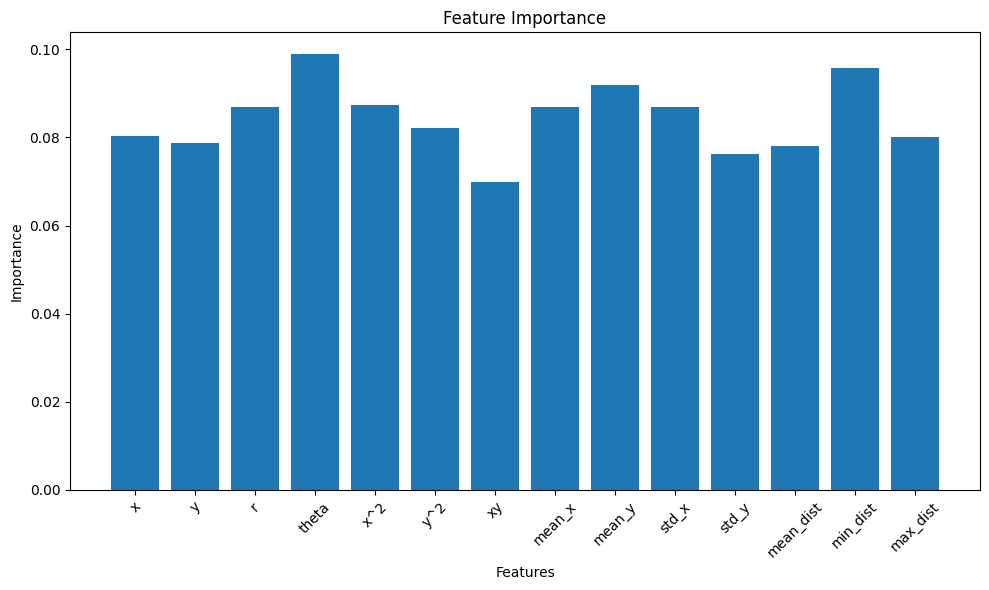

In [2]:
# Example usage with the improved GNN workflow
if __name__ == "__main__":
    # Path to the dataset file
    h5_file_path = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"
    
    # Initialize GNN pipeline
    pipeline = CellTypeGATModel(h5_file_path, random_state=42)
    
    # Load all training data
    train_spot_tables = pipeline.load_train_data()
    
    # Prepare training set with graph features from all available slides
    node_features, adjacency_lists, edge_features, y_train = pipeline.prepare_training_set(normalize=True)
    
    # Visualize the graph structure for a small subset
    # Note: You need to implement the visualize_graph method if needed
    sample_slide = list(pipeline.train_spot_tables.keys())[0]
    sample_df = pipeline.train_spot_tables[sample_slide].head(100)
    
    # Uncomment this if you implement the visualize_graph method
    # pipeline.visualize_graph(
    #     sample_df,
    #     adjacency_lists[:100],
    #     edge_features[:100] if edge_features is not None else None,
    #     cell_type_index=0  # Visualize for the first cell type
    # )
    
    # Perform cross-validation
    cv_results = pipeline.cross_validate(
        node_features, 
        adjacency_lists, 
        y_train, 
        edge_features=edge_features,
        n_splits=5, 
        batch_size=64,
        epochs=500,
        early_stopping=True,
        patience=15
    )
    
    # Analyze cross-validation results
    print(f"Cross-validation mean MSE: {np.mean(cv_results['mse_scores']):.4f}")
    print(f"Cross-validation mean R²: {np.mean(cv_results['r2_scores']):.4f}")
    
    # Optional: Plot cross-validation results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.boxplot(cv_results['mse_scores'])
    plt.title('MSE Scores Distribution')
    plt.ylabel('Mean Squared Error')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(cv_results['r2_scores'])
    plt.title('R² Scores Distribution')
    plt.ylabel('R² Score')
    
    plt.tight_layout()
    plt.show()
    
    # Train final model on full dataset with early stopping
    pipeline.build_model(
        input_dim=node_features.shape[1], 
        dropout_rate=0.5, 
        l2_reg=0.001,
        learning_rate=0.0001,
        n_heads=8
    )
    
    final_model, history = pipeline.train(
        node_features, 
        adjacency_lists, 
        y_train,
        edge_features=edge_features,
        validation_split=0.2,
        batch_size=64,
        epochs=500,
        early_stopping=True,
        patience=15,
        reduce_lr=True
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Generate predictions for all test slides
    test_slides = []
    with h5py.File(h5_file_path, "r") as f:
        test_spots = f["spots/Test"]
        test_slides = list(test_spots.keys())
    
    all_predictions = {}
    all_submission_dfs = {}
    
    for slide_id in test_slides:
        print(f"Processing test slide: {slide_id}")
        
        # Load test data with graph structure
        test_df, test_node_features, test_adjacency_lists, test_edge_features = pipeline.load_test_data(
            slide_id=slide_id, 
            normalize=True
        )
        
        # Generate predictions
        predictions = pipeline.predict(test_node_features)
        all_predictions[slide_id] = predictions
        
        # Create submission for this slide
        submission_df = pipeline.create_submission(
            test_df, 
            predictions, 
            submission_filename=f"submission_{slide_id}.csv"
        )
        
        all_submission_dfs[slide_id] = submission_df
    
    # Combine all submissions into one file if needed
    combined_submission = pd.concat(list(all_submission_dfs.values()), axis=0)
    combined_submission.to_csv("submission.csv", index=False)
    
    print("Pipeline execution completed successfully!")
    
    # Optional: Feature importance analysis
    # If you want to analyze which features are most important
    # This is a simple approach - for more advanced analysis you might 
    # need to modify the model architecture
    
    if hasattr(pipeline.model, 'layers') and len(pipeline.model.layers) > 1:
        first_layer_weights = pipeline.model.layers[1].get_weights()[0]
        feature_importance = np.mean(np.abs(first_layer_weights), axis=1)
        
        # Create feature names based on the node features created
        # This is an approximation - actual feature names depend on create_graph_features implementation
        base_features = ['x', 'y', 'r', 'theta', 'x^2', 'y^2', 'xy']
        neighbor_features = ['mean_x', 'mean_y', 'std_x', 'std_y', 'mean_dist', 'min_dist', 'max_dist']
        feature_names = base_features + neighbor_features
        
        # Plot feature importance if possible
        if len(feature_names) == len(feature_importance):
            plt.figure(figsize=(10, 6))
            plt.bar(feature_names, feature_importance)
            plt.title('Feature Importance')
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

In [3]:
# Detailed inspection of each layer
print("\nDetailed Model Architecture:")
for i, layer in enumerate(pipeline.model.layers):
    print(f"Layer {i}: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
   # print(f"  Input shape: {layer.input_shape}")
#    print(f"  Output shape: {layer.output_shape}")
    print(f"  Parameters: {layer.count_params()}")
    print(f"  Trainable: {layer.trainable}")
    print("")


Detailed Model Architecture:
Layer 0: node_features
  Type: InputLayer
  Parameters: 0
  Trainable: True

Layer 1: dense_25
  Type: Dense
  Parameters: 1920
  Trainable: True

Layer 2: batch_normalization_20
  Type: BatchNormalization
  Parameters: 512
  Trainable: True

Layer 3: dropout_20
  Type: Dropout
  Parameters: 0
  Trainable: True

Layer 4: dense_26
  Type: Dense
  Parameters: 33024
  Trainable: True

Layer 5: batch_normalization_21
  Type: BatchNormalization
  Parameters: 1024
  Trainable: True

Layer 6: dropout_21
  Type: Dropout
  Parameters: 0
  Trainable: True

Layer 7: dense_27
  Type: Dense
  Parameters: 131584
  Trainable: True

Layer 8: batch_normalization_22
  Type: BatchNormalization
  Parameters: 2048
  Trainable: True

Layer 9: dropout_22
  Type: Dropout
  Parameters: 0
  Trainable: True

Layer 10: dense_28
  Type: Dense
  Parameters: 525312
  Trainable: True

Layer 11: batch_normalization_23
  Type: BatchNormalization
  Parameters: 4096
  Trainable: True

Layer 

In [4]:
# Print model summary
pipeline.model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ node_features (InputLayer)           │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 35)                  │          35,875 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,198,507 (8.39 MB)

 Trainable params: 731,555 (2.79 MB)

 Non-trainable params: 3,840 (15.00 KB)

 Optimizer params: 1,463,112 (5.58 MB)